In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# ML libs
import torch
import torch.nn as nn

from pypfopt import EfficientFrontier, risk_models, expected_returns
from utils.paths import ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, EQUITY_DIR

## Benchmark Portfolio ($W_{\text{old}}$)

### 1.1 Preprocess data

#### Read a CSV file

In [2]:
tech_stocks_pth = os.path.join(PROCESSED_DIR, "tech_stocks_us_equity_1d.csv")
tech_stocks_df = pd.read_csv(tech_stocks_pth)
# stocks_eq_df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
tech_stocks_df.head()

/tmp/ipykernel_117435/736789253.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

Price Price.1 Price.2              Close            Close.1  \
0      Ticker    ANSS    JNPR               AAPL                ACN   
1        Date     NaN     NaN                NaN                NaN   
2  2015-01-02     NaN     NaN  24.26104164123535  74.25262451171875   
3  2015-01-05     NaN     NaN  23.57756996154785  72.99890899658203   
4  2015-01-06     NaN     NaN  23.57979393005371  72.47238159179688   

             Close.2            Close.3            Close.4  \
0               ADBE                ADI                ADP   
1                NaN                NaN                NaN   
2  72.33999633789062  44.51115036010742  65.98639678955078   
3   71.9800033569336  43.70171356201172  65.93885803222656   
4  70.52999877929688  42.67587661743164   65.3922348022461   

              Close.5             Close.6  ... Volume.72 Volume.73 Volume.74  \
0                ADSK                AKAM  ...       TDY       TEL       TER   
1                 NaN                 NaN  ...       NaN       NaN       NaN   
2  59.529998779296875               63.25  ...    145700    948900   1030300   
3   58.65999984741211  61.939998626708984  ...    266200    953400   1877000   
4                57.5   60.66999816894531  ...    243000   1448800   2377700   

  Volume.75 Volume.76 Volume.77 Volume.78 Volume.79 Volume.80 Volume.81  
0      TRMB       TXN       TYL      UBER      VRSN       WDC      ZBRA  
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2   1106000   4020100    216200       NaN    684500   1278547    411800  
3   1254900   5599300    270300       NaN    874400   2199752    420300  
4   2291600   5468400    239600       NaN   1289300   2665713    527500  

[5 rows x 413 columns]

#### Parse Columns

In [3]:
parsed_columns = []
# Loop each columns
for col_name in tech_stocks_df.columns:
    
    parts = col_name.split('.') # แยกชื่อด้วยจุด
    feature = parts[0]
    ticker = tech_stocks_df.loc[0, col_name]

    # เพิ่ม (Feature, Ticker_ID) เข้าไปใน List
    parsed_columns.append((feature, ticker))

# Applying MultiIndex
new_index = pd.MultiIndex.from_tuples(parsed_columns, names=['Feature', 'Ticker'])
tech_stocks_df.columns = new_index

tech_stocks_df.head(2)

Feature   Price             Close                                   ...  \
Ticker   Ticker  ANSS  JNPR  AAPL  ACN  ADBE  ADI  ADP  ADSK  AKAM  ...   
0        Ticker  ANSS  JNPR  AAPL  ACN  ADBE  ADI  ADP  ADSK  AKAM  ...   
1          Date   NaN   NaN   NaN  NaN   NaN  NaN  NaN   NaN   NaN  ...   

Feature Volume                                                   
Ticker     TDY  TEL  TER  TRMB  TXN  TYL  UBER  VRSN  WDC  ZBRA  
0          TDY  TEL  TER  TRMB  TXN  TYL  UBER  VRSN  WDC  ZBRA  
1          NaN  NaN  NaN   NaN  NaN  NaN   NaN   NaN  NaN   NaN  

[2 rows x 413 columns]

#### Remove 2 rows

In [4]:
# Remove 2 rows
tech_stocks_df = tech_stocks_df.iloc[2:]
tech_stocks_df = tech_stocks_df.reset_index(drop=True)
tech_stocks_df.head()

Feature       Price                         Close                     \
Ticker       Ticker ANSS JNPR                AAPL                ACN   
0        2015-01-02  NaN  NaN   24.26104164123535  74.25262451171875   
1        2015-01-05  NaN  NaN   23.57756996154785  72.99890899658203   
2        2015-01-06  NaN  NaN   23.57979393005371  72.47238159179688   
3        2015-01-07  NaN  NaN  23.910430908203125  73.99351501464844   
4        2015-01-08  NaN  NaN  24.829124450683594   75.1218490600586   

Feature                                                           \
Ticker                ADBE                ADI                ADP   
0        72.33999633789062  44.51115036010742  65.98639678955078   
1         71.9800033569336  43.70171356201172  65.93885803222656   
2        70.52999877929688  42.67587661743164   65.3922348022461   
3        71.11000061035156  43.12467956542969    65.962646484375   
4        72.91999816894531  43.88603591918945  67.47581481933594   

Feature                                          ...  Volume           \
Ticker                 ADSK                AKAM  ...     TDY      TEL   
0        59.529998779296875               63.25  ...  145700   948900   
1         58.65999984741211  61.939998626708984  ...  266200   953400   
2                      57.5   60.66999816894531  ...  243000  1448800   
3        57.380001068115234   60.15999984741211  ...  245300  1929000   
4         58.79999923706055   61.56999969482422  ...  240300  1635300   

Feature                                                                    
Ticker       TER     TRMB      TXN     TYL UBER     VRSN      WDC    ZBRA  
0        1030300  1106000  4020100  216200  NaN   684500  1278547  411800  
1        1877000  1254900  5599300  270300  NaN   874400  2199752  420300  
2        2377700  2291600  5468400  239600  NaN  1289300  2665713  527500  
3         902400  2096400  4577100  220300  NaN   552400  2054222  467800  
4        1626800  2036000  6295200  264700  NaN  1282600  3351291  324400  

[5 rows x 413 columns]

#### Set Indexes

In [5]:
# 1. Get col name
first_col_name = tech_stocks_df.columns[0]

# 2. Covert Cols to datetime
tech_stocks_df[first_col_name] = pd.to_datetime(tech_stocks_df[first_col_name])

# 3. Set Col be Index
tech_stocks_df = tech_stocks_df.set_index(first_col_name, drop=True)

# 4. Change index name
tech_stocks_df.index.name = 'Date'

tech_stocks_df.head()

Feature    Price                    Close                     \
Ticker      ANSS JNPR                AAPL                ACN   
Date                                                           
2015-01-02   NaN  NaN   24.26104164123535  74.25262451171875   
2015-01-05   NaN  NaN   23.57756996154785  72.99890899658203   
2015-01-06   NaN  NaN   23.57979393005371  72.47238159179688   
2015-01-07   NaN  NaN  23.910430908203125  73.99351501464844   
2015-01-08   NaN  NaN  24.829124450683594   75.1218490600586   

Feature                                                              \
Ticker                   ADBE                ADI                ADP   
Date                                                                  
2015-01-02  72.33999633789062  44.51115036010742  65.98639678955078   
2015-01-05   71.9800033569336  43.70171356201172  65.93885803222656   
2015-01-06  70.52999877929688  42.67587661743164   65.3922348022461   
2015-01-07  71.11000061035156  43.12467956542969    65.962646484375   
2015-01-08  72.91999816894531  43.88603591918945  67.47581481933594   

Feature                                                                 ...  \
Ticker                    ADSK                AKAM                AMAT  ...   
Date                                                                    ...   
2015-01-02  59.529998779296875               63.25  21.807235717773438  ...   
2015-01-05   58.65999984741211  61.939998626708984  21.108293533325195  ...   
2015-01-06                57.5   60.66999816894531     20.313232421875  ...   
2015-01-07  57.380001068115234   60.15999984741211  20.505441665649414  ...   
2015-01-08   58.79999923706055   61.56999969482422   21.16071128845215  ...   

Feature     Volume                                                            \
Ticker         TDY      TEL      TER     TRMB      TXN     TYL UBER     VRSN   
Date                                                                           
2015-01-02  145700   948900  1030300  1106000  4020100  216200  NaN   684500   
2015-01-05  266200   953400  1877000  1254900  5599300  270300  NaN   874400   
2015-01-06  243000  1448800  2377700  2291600  5468400  239600  NaN  1289300   
2015-01-07  245300  1929000   902400  2096400  4577100  220300  NaN   552400   
2015-01-08  240300  1635300  1626800  2036000  6295200  264700  NaN  1282600   

Feature                      
Ticker          WDC    ZBRA  
Date                         
2015-01-02  1278547  411800  
2015-01-05  2199752  420300  
2015-01-06  2665713  527500  
2015-01-07  2054222  467800  
2015-01-08  3351291  324400  

[5 rows x 412 columns]

#### Drop Price Column

In [6]:
tech_stocks_df = tech_stocks_df.drop(columns="Price", level="Feature")
tech_stocks_df.head()

Feature                  Close                                        \
Ticker                    AAPL                ACN               ADBE   
Date                                                                   
2015-01-02   24.26104164123535  74.25262451171875  72.33999633789062   
2015-01-05   23.57756996154785  72.99890899658203   71.9800033569336   
2015-01-06   23.57979393005371  72.47238159179688  70.52999877929688   
2015-01-07  23.910430908203125  73.99351501464844  71.11000061035156   
2015-01-08  24.829124450683594   75.1218490600586  72.91999816894531   

Feature                                                               \
Ticker                    ADI                ADP                ADSK   
Date                                                                   
2015-01-02  44.51115036010742  65.98639678955078  59.529998779296875   
2015-01-05  43.70171356201172  65.93885803222656   58.65999984741211   
2015-01-06  42.67587661743164   65.3922348022461                57.5   
2015-01-07  43.12467956542969    65.962646484375  57.380001068115234   
2015-01-08  43.88603591918945  67.47581481933594   58.79999923706055   

Feature                                                                 \
Ticker                    AKAM                AMAT                 AMD   
Date                                                                     
2015-01-02               63.25  21.807235717773438  2.6700000762939453   
2015-01-05  61.939998626708984  21.108293533325195  2.6600000858306885   
2015-01-06   60.66999816894531     20.313232421875   2.630000114440918   
2015-01-07   60.15999984741211  20.505441665649414  2.5799999237060547   
2015-01-08   61.56999969482422   21.16071128845215   2.609999895095825   

Feature                         ...  Volume                             \
Ticker                    ANET  ...     TDY      TEL      TER     TRMB   
Date                            ...                                      
2015-01-02  3.9175000190734863  ...  145700   948900  1030300  1106000   
2015-01-05   3.987499952316284  ...  266200   953400  1877000  1254900   
2015-01-06  3.9881250858306885  ...  243000  1448800  2377700  2291600   
2015-01-07   4.071249961853027  ...  245300  1929000   902400  2096400   
2015-01-08   4.132500171661377  ...  240300  1635300  1626800  2036000   

Feature                                                     
Ticker          TXN     TYL UBER     VRSN      WDC    ZBRA  
Date                                                        
2015-01-02  4020100  216200  NaN   684500  1278547  411800  
2015-01-05  5599300  270300  NaN   874400  2199752  420300  
2015-01-06  5468400  239600  NaN  1289300  2665713  527500  
2015-01-07  4577100  220300  NaN   552400  2054222  467800  
2015-01-08  6295200  264700  NaN  1282600  3351291  324400  

[5 rows x 410 columns]

In [7]:
tech_stocks_df = tech_stocks_df.dropna(axis=1, how='all')

In [8]:
tech_stocks_df["Close"].head()

Ticker                    AAPL                ACN               ADBE  \
Date                                                                   
2015-01-02   24.26104164123535  74.25262451171875  72.33999633789062   
2015-01-05   23.57756996154785  72.99890899658203   71.9800033569336   
2015-01-06   23.57979393005371  72.47238159179688  70.52999877929688   
2015-01-07  23.910430908203125  73.99351501464844  71.11000061035156   
2015-01-08  24.829124450683594   75.1218490600586  72.91999816894531   

Ticker                    ADI                ADP                ADSK  \
Date                                                                   
2015-01-02  44.51115036010742  65.98639678955078  59.529998779296875   
2015-01-05  43.70171356201172  65.93885803222656   58.65999984741211   
2015-01-06  42.67587661743164   65.3922348022461                57.5   
2015-01-07  43.12467956542969    65.962646484375  57.380001068115234   
2015-01-08  43.88603591918945  67.47581481933594   58.79999923706055   

Ticker                    AKAM                AMAT                 AMD  \
Date                                                                     
2015-01-02               63.25  21.807235717773438  2.6700000762939453   
2015-01-05  61.939998626708984  21.108293533325195  2.6600000858306885   
2015-01-06   60.66999816894531     20.313232421875   2.630000114440918   
2015-01-07   60.15999984741211  20.505441665649414  2.5799999237060547   
2015-01-08   61.56999969482422   21.16071128845215   2.609999895095825   

Ticker                    ANET  ...                 TDY                 TEL  \
Date                            ...                                           
2015-01-02  3.9175000190734863  ...  102.16000366210938  51.678226470947266   
2015-01-05   3.987499952316284  ...   99.72000122070312   50.67198181152344   
2015-01-06  3.9881250858306885  ...    98.0199966430664   50.05843734741211   
2015-01-07   4.071249961853027  ...   98.79000091552734   51.56367111206055   
2015-01-08   4.132500171661377  ...  100.44000244140625    52.6026725769043   

Ticker                     TER                TRMB                TXN  \
Date                                                                    
2015-01-02  18.317794799804688   26.90999984741211  39.91105651855469   
2015-01-05   17.97374725341797  26.030000686645508  39.29164123535156   
2015-01-06  17.425148010253906   25.65999984741211  38.64237594604492   
2015-01-07  17.564624786376953   25.34000015258789   39.3364143371582   
2015-01-08   18.11322593688965  25.670000076293945  39.97822570800781   

Ticker                     TYL UBER                VRSN                WDC  \
Date                                                                         
2015-01-02   107.8499984741211  NaN   56.87038803100586  69.89840698242188   
2015-01-05  105.97000122070312  NaN  55.925697326660156  68.97427368164062   
2015-01-06  104.91000366210938  NaN   54.87162399291992  67.43614959716797   
2015-01-07  106.02999877929688  NaN   55.32905197143555  68.44889068603516   
2015-01-08  109.19999694824219  NaN   56.56212615966797  69.86673736572266   

Ticker                   ZBRA  
Date                           
2015-01-02  77.43000030517578  
2015-01-05  76.33999633789062  
2015-01-06  75.79000091552734  
2015-01-07  77.72000122070312  
2015-01-08  79.37999725341797  

[5 rows x 80 columns]

### 1.2 Calc Input (μ_old, Σ_old)

In [9]:
prices = tech_stocks_df["Close"].astype(float)

# Calc μ_old (Expected Return)
mu_old = expected_returns.mean_historical_return(prices)

# Calc Σ_old (Covariance Matrix)
sigma_old = risk_models.sample_cov(prices)

print("\nμ_old (Mean Historical Returns):")
print(mu_old)
print("\nΣ_old (Historical Covariance Matrix):")
print(sigma_old.head())


μ_old (Mean Historical Returns):
Ticker
AAPL    0.250409
ACN     0.118592
ADBE    0.153744
ADI     0.165500
ADP     0.135921
          ...   
TYL     0.147749
UBER    0.139220
VRSN    0.140583
WDC     0.065067
ZBRA    0.119169
Length: 80, dtype: float64

Σ_old (Historical Covariance Matrix):
Ticker      AAPL       ACN      ADBE       ADI       ADP      ADSK      AKAM  \
Ticker                                                                         
AAPL    0.084218  0.039273  0.054383  0.053567  0.033732  0.054443  0.034482   
ACN     0.039273  0.063489  0.047760  0.043708  0.037415  0.050122  0.034353   
ADBE    0.054383  0.047760  0.109413  0.056501  0.039162  0.073854  0.043465   
ADI     0.053567  0.043708  0.056501  0.103762  0.038131  0.063018  0.036206   
ADP     0.033732  0.037415  0.039162  0.038131  0.055921  0.042057  0.028744   

Ticker      AMAT       AMD      ANET  ...       TDY       TEL       TER  \
Ticker                                ...                             

### 1.3 New Portfolio with W_old

In [10]:
prices.head()

Ticker           AAPL        ACN       ADBE        ADI        ADP       ADSK  \
Date                                                                           
2015-01-02  24.261042  74.252625  72.339996  44.511150  65.986397  59.529999   
2015-01-05  23.577570  72.998909  71.980003  43.701714  65.938858  58.660000   
2015-01-06  23.579794  72.472382  70.529999  42.675877  65.392235  57.500000   
2015-01-07  23.910431  73.993515  71.110001  43.124680  65.962646  57.380001   
2015-01-08  24.829124  75.121849  72.919998  43.886036  67.475815  58.799999   

Ticker           AKAM       AMAT   AMD      ANET  ...         TDY        TEL  \
Date                                              ...                          
2015-01-02  63.250000  21.807236  2.67  3.917500  ...  102.160004  51.678226   
2015-01-05  61.939999  21.108294  2.66  3.987500  ...   99.720001  50.671982   
2015-01-06  60.669998  20.313232  2.63  3.988125  ...   98.019997  50.058437   
2015-01-07  60.160000  20.505442  2.58  4.071250  ...   98.790001  51.563671   
2015-01-08  61.570000  21.160711  2.61  4.132500  ...  100.440002  52.602673   

Ticker            TER       TRMB        TXN         TYL  UBER       VRSN  \
Date                                                                       
2015-01-02  18.317795  26.910000  39.911057  107.849998   NaN  56.870388   
2015-01-05  17.973747  26.030001  39.291641  105.970001   NaN  55.925697   
2015-01-06  17.425148  25.660000  38.642376  104.910004   NaN  54.871624   
2015-01-07  17.564625  25.340000  39.336414  106.029999   NaN  55.329052   
2015-01-08  18.113226  25.670000  39.978226  109.199997   NaN  56.562126   

Ticker            WDC       ZBRA  
Date                              
2015-01-02  69.898407  77.430000  
2015-01-05  68.974274  76.339996  
2015-01-06  67.436150  75.790001  
2015-01-07  68.448891  77.720001  
2015-01-08  69.866737  79.379997  

[5 rows x 80 columns]

In [11]:
prices = prices.replace('NaN', np.nan)
prices = prices.dropna()
prices.head()

Ticker            AAPL         ACN        ADBE         ADI         ADP  \
Date                                                                     
2020-09-30  112.650444  209.528778  490.429993  106.881973  125.874504   
2020-10-01  113.603714  208.777725  499.510010  108.941978  124.259232   
2020-10-02  109.936562  206.200226  478.989990  104.382507  125.134537   
2020-10-05  113.321632  207.210861  486.470001  106.753792  127.201050   
2020-10-06  110.072754  204.299576  478.980011  105.783318  128.374115   

Ticker            ADSK        AKAM       AMAT        AMD       ANET  ...  \
Date                                                                 ...   
2020-09-30  231.009995  110.540001  56.874863  81.989998  12.933125  ...   
2020-10-01  233.960007  109.930000  58.022873  84.860001  12.940625  ...   
2020-10-02  225.559998  108.610001  55.688572  81.800003  12.743750  ...   
2020-10-05  228.929993  109.099998  57.975037  86.150002  12.875000  ...   
2020-10-06  228.009995  108.160004  57.783703  84.480003  12.925000  ...   

Ticker             TDY        TEL        TER       TRMB         TXN  \
Date                                                                  
2020-09-30  310.209991  90.041351  77.857590  48.700001  124.092392   
2020-10-01  307.750000  90.787567  79.660492  48.869999  125.934837   
2020-10-02  309.809998  90.612549  77.034538  49.330002  122.615051   
2020-10-05  315.519989  93.385452  79.591888  50.720001  125.213501   
2020-10-06  314.869995  93.809212  79.474327  48.930000  125.013626   

Ticker             TYL       UBER        VRSN        WDC        ZBRA  
Date                                                                  
2020-09-30  348.559998  36.480000  203.705185  27.543163  252.460007  
2020-10-01  357.260010  37.139999  206.061935  27.377378  258.480011  
2020-10-02  350.720001  37.720001  201.030212  27.098555  258.809998  
2020-10-05  357.170013  37.139999  202.313004  27.558235  268.010010  
2020-10-06  363.940002  36.259998  200.960602  27.324627  269.970001  

[5 rows x 80 columns]

In [12]:
# Set MPT Optimizer with old Input
ef = EfficientFrontier(mu_old, sigma_old)
print(ef)
try:
    weights_old_raw = ef.max_sharpe()
    
    # Clean (Round decimals)
    weights_old = ef.clean_weights()
    
    # Result of W_old
    w_old_df = pd.Series(weights_old, name="W_old (Benchmark)")
    print(w_old_df)
    print("------\n")
    print(w_old_df[w_old_df > 0])

    print("\nExpected Performance (From historical data):")
    ef.portfolio_performance(verbose=True)

except ValueError as e:
    print(f"Fail to calc portfolio: {e}")

AAPL    0.0
ACN     0.0
ADBE    0.0
ADI     0.0
ADP     0.0
       ... 
TYL     0.0
UBER    0.0
VRSN    0.0
WDC     0.0
ZBRA    0.0
Name: W_old (Benchmark), Length: 80, dtype: float64
------

AVGO    0.05247
FICO    0.04110
LDOS    0.21341
MSI     0.12304
NVDA    0.42922
PLTR    0.14076
Name: W_old (Benchmark), dtype: float64

Expected Performance (From historical data):
Expected annual return: 54.2%
Annual volatility: 32.6%
Sharpe Ratio: 1.66


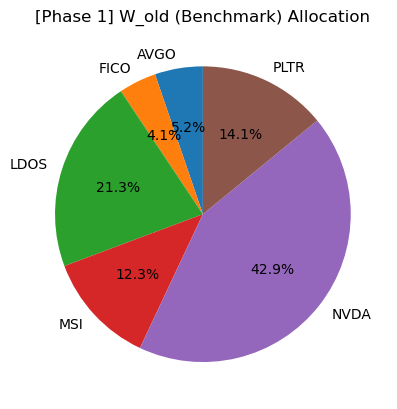

In [13]:
w_old_series = w_old_df[w_old_df > 0].copy()
w_old_series.plot.pie(
    autopct='%1.1f%%',  # Display as percentage
    startangle=90,       # Begin at 90 degrees
    title='[Phase 1] W_old (Benchmark) Allocation'
)
plt.ylabel('') # remove label on Y axis 
plt.show()

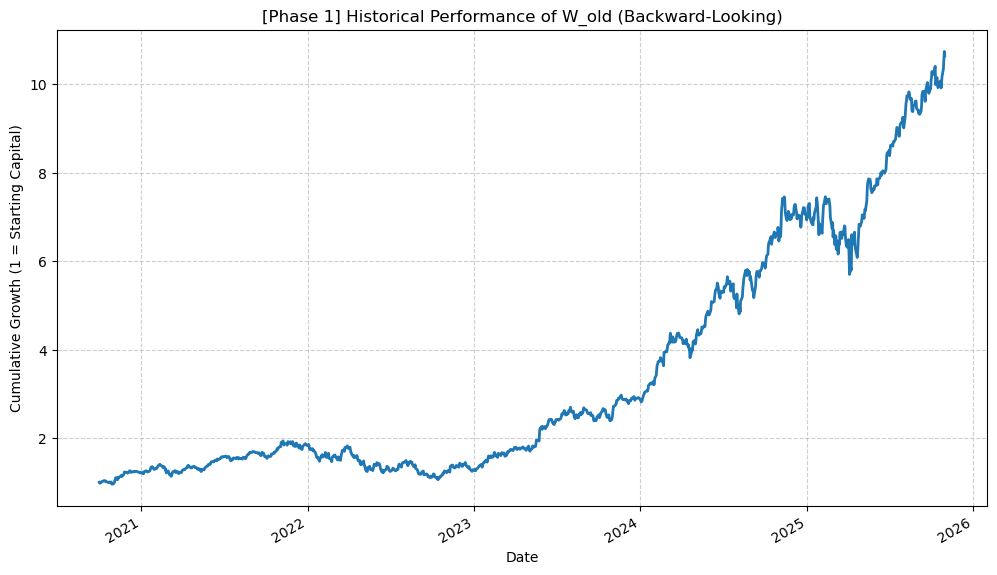

In [14]:
w_old_series = w_old_df.copy()

# 1. คำนวณผลตอบแทนรายวันของสินทรัพย์
returns_old = prices.pct_change().dropna()

# 2. คำนวณผลตอบแทนรายวันของ "พอร์ต" (จากสัดส่วน W_old)
portfolio_returns_old = (returns_old * w_old_series).sum(axis=1)

# 3. คำนวณผลตอบแทนสะสม (ทบต้น)
cumulative_returns_old = (1 + portfolio_returns_old).cumprod()

# 4. พล็อต
plt.figure(figsize=(12, 7))
cumulative_returns_old.plot(
    title='[Phase 1] Historical Performance of W_old (Backward-Looking)',
    lw=2 # ความหนาเส้น
)
plt.xlabel('Date')
plt.ylabel('Cumulative Growth (1 = Starting Capital)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Diffusion Model

In [15]:
prices.head(5)

Ticker            AAPL         ACN        ADBE         ADI         ADP  \
Date                                                                     
2020-09-30  112.650444  209.528778  490.429993  106.881973  125.874504   
2020-10-01  113.603714  208.777725  499.510010  108.941978  124.259232   
2020-10-02  109.936562  206.200226  478.989990  104.382507  125.134537   
2020-10-05  113.321632  207.210861  486.470001  106.753792  127.201050   
2020-10-06  110.072754  204.299576  478.980011  105.783318  128.374115   

Ticker            ADSK        AKAM       AMAT        AMD       ANET  ...  \
Date                                                                 ...   
2020-09-30  231.009995  110.540001  56.874863  81.989998  12.933125  ...   
2020-10-01  233.960007  109.930000  58.022873  84.860001  12.940625  ...   
2020-10-02  225.559998  108.610001  55.688572  81.800003  12.743750  ...   
2020-10-05  228.929993  109.099998  57.975037  86.150002  12.875000  ...   
2020-10-06  228.009995  108.160004  57.783703  84.480003  12.925000  ...   

Ticker             TDY        TEL        TER       TRMB         TXN  \
Date                                                                  
2020-09-30  310.209991  90.041351  77.857590  48.700001  124.092392   
2020-10-01  307.750000  90.787567  79.660492  48.869999  125.934837   
2020-10-02  309.809998  90.612549  77.034538  49.330002  122.615051   
2020-10-05  315.519989  93.385452  79.591888  50.720001  125.213501   
2020-10-06  314.869995  93.809212  79.474327  48.930000  125.013626   

Ticker             TYL       UBER        VRSN        WDC        ZBRA  
Date                                                                  
2020-09-30  348.559998  36.480000  203.705185  27.543163  252.460007  
2020-10-01  357.260010  37.139999  206.061935  27.377378  258.480011  
2020-10-02  350.720001  37.720001  201.030212  27.098555  258.809998  
2020-10-05  357.170013  37.139999  202.313004  27.558235  268.010010  
2020-10-06  363.940002  36.259998  200.960602  27.324627  269.970001  

[5 rows x 80 columns]

### Transform Prices to log returns.

$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$

In [16]:
log_returns = np.log(prices / prices.shift(1)).dropna()
log_returns.head(5)

Ticker          AAPL       ACN      ADBE       ADI       ADP      ADSK  \
Date                                                                     
2020-10-01  0.008427 -0.003591  0.018345  0.019090 -0.012915  0.012689   
2020-10-02 -0.032813 -0.012423 -0.041948 -0.042753  0.007019 -0.036564   
2020-10-05  0.030327  0.004889  0.015496  0.022463  0.016379  0.014830   
2020-10-06 -0.029089 -0.014150 -0.015516 -0.009132  0.009180 -0.004027   
2020-10-07  0.016825  0.013971  0.029155  0.026730  0.010281  0.021692   

Ticker          AKAM      AMAT       AMD      ANET  ...       TDY       TEL  \
Date                                                ...                       
2020-10-01 -0.005534  0.019984  0.034406  0.000580  ... -0.007962  0.008253   
2020-10-02 -0.012080 -0.041062 -0.036726 -0.015331  ...  0.006671 -0.001930   
2020-10-05  0.004501  0.040238  0.051813  0.010247  ...  0.018263  0.030143   
2020-10-06 -0.008653 -0.003306 -0.019575  0.003876  ... -0.002062  0.004527   
2020-10-07  0.013955  0.011850  0.025824  0.024787  ...  0.009483  0.026361   

Ticker           TER      TRMB       TXN       TYL      UBER      VRSN  \
Date                                                                     
2020-10-01  0.022892  0.003485  0.014738  0.024653  0.017930  0.011503   
2020-10-02 -0.033520  0.009369 -0.026715 -0.018476  0.015496 -0.024722   
2020-10-05  0.032658  0.027788  0.020971  0.018224 -0.015496  0.006361   
2020-10-06 -0.001478 -0.035930 -0.001598  0.018777 -0.023979 -0.006707   
2020-10-07  0.014443  0.031781  0.019959  0.031962  0.014239  0.008524   

Ticker           WDC      ZBRA  
Date                            
2020-10-01 -0.006037  0.023566  
2020-10-02 -0.010237  0.001276  
2020-10-05  0.016821  0.034930  
2020-10-06 -0.008513  0.007287  
2020-10-07  0.034958  0.024189  

[5 rows x 80 columns]

In [17]:
data = log_returns.values
data

array([[ 0.00842659, -0.00359093,  0.0183451 , ...,  0.011503  ,
        -0.00603728,  0.02356552],
       [-0.03281271, -0.0124225 , -0.04194794, ..., -0.02472157,
        -0.01023668,  0.00127583],
       [ 0.03032659,  0.00488926,  0.01549554, ...,  0.00636081,
         0.01682102,  0.03493014],
       ...,
       [ 0.00070658,  0.01023575,  0.00587987, ..., -0.02809925,
        -0.01391175, -0.1241505 ],
       [ 0.0025989 , -0.02235178, -0.06322245, ..., -0.03191373,
         0.12377782, -0.01298913],
       [ 0.00628345,  0.00603624,  0.00407623, ...,  0.01186982,
        -0.02325603, -0.0353327 ]], shape=(1277, 80))

In [18]:
window_size = 60 # each timeframe equals 60 days

# Use a `sliding_window_view` technic of NumPy (comfortable)
# Create a "Window" slides each day
# Make sure that it's C-contiguous (numpy technical)
data_contiguous = np.ascontiguousarray(data)
all_windows = np.lib.stride_tricks.sliding_window_view(
    data_contiguous, 
    window_shape=(window_size, data.shape[1])
)

# all_windows will have shape (N=shape[1]=80, 1, window_size=60, 5)
all_windows = all_windows.squeeze(axis=1)
dataset = all_windows
print(f"Raw data shape: {data.shape}")
print(f"Pretrain data (Windowed) shape: {dataset.shape}")

Raw data shape: (1277, 80)
Pretrain data (Windowed) shape: (1218, 60, 80)


In [19]:
# Model Structal (Just a idea)
class DiffusionDenoisingModel(nn.Module):
    def __init__(self, n_assets=5, window_size=60):
        super().__init__()
        self.n_assets = n_assets
        self.window_size = window_size
        
        # ... ที่จริงตรงนี้ต้องมีโครงข่าย U-Net หรือ Transformer ที่ซับซ้อน ...
        # ... เพื่อรับ Input (noisy_data, timestep) และพ่น Output (predicted_noise) ...
        self.model = nn.Sequential(
            nn.Linear(window_size * n_assets, 1024),
            nn.ReLU(),
            nn.Linear(1024, window_size * n_assets)
        ) # นี่เป็นแค่ตัวอย่างที่ง่ายมากๆ นะครับ

    def forward(self, noisy_data, timestep):
        # (ต้องจัดการ timestep embedding ด้วย)
        # ...
        # predict_noise = self.model(noisy_data)
        # return predict_noise
        pass

In [20]:
# Helper Class: สำหรับแปลง 'timestep' (เช่น 5, 100, 750)
# ให้เป็น 'Vector' ที่มีความหมาย (Time Embedding)
# (นี่คือเทคนิคจาก Transformer)
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # time.shape = [Batch]
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # return shape [Batch, dim]
        return embeddings

In [21]:
# Model Structal (ฉบับปรับปรุงที่รับ 'timestep' ได้)
class SimpleDenoisingModel(nn.Module):
    def __init__(self, n_assets=5, window_size=60, time_emb_dim=128):
        super().__init__()
        self.n_assets = n_assets
        self.window_size = window_size
        
        # 1. ตัวแปลง 'เวลา' (เลข 1-1000) ให้เป็น Vector
        self.time_embedder = SinusoidalPositionEmbeddings(time_emb_dim)

        # 2. คำนวณมิติ Input
        #    (60 * 5) + 128 = ข้อมูลที่ยืดแล้ว + เวกเตอร์เวลา
        input_dim = (window_size * n_assets) + time_emb_dim
        
        # 3. มิติ Output (ต้องเดา Noise กลับ)
        output_dim = window_size * n_assets

        # 4. โมเดล MLP (เหมือนของคุณ แต่ Input/Output ถูกต้อง)
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024), # เพิ่มชั้นเพื่อความซับซ้อน
            nn.ReLU(),
            nn.Linear(1024, output_dim) # ทำนาย Noise ที่ยืดแล้ว
        )

    # นี่คือส่วนที่สำคัญ!
    def forward(self, noisy_data, timestep):
        # noisy_data shape: [Batch, 60, 5]
        # timestep shape: [Batch,] (เช่น [10, 500, 999])

        # 1. "ยืด" ข้อมูล (Flatten)
        #    Shape: [Batch, 300] (คือ 60 * 5)
        data_flat = noisy_data.view(noisy_data.shape[0], -1) 

        # 2. "แปลง" เวลา
        #    Shape: [Batch, 128]
        t_emb = self.time_embedder(timestep)

        # 3. "รวม" ข้อมูล + เวลา
        #    Shape: [Batch, 300 + 128]
        combined_input = torch.cat([data_flat, t_emb], dim=1)

        # 4. ยัดเข้าโมเดล
        predicted_noise_flat = self.model(combined_input)

        # 5. "หด" กลับเป็น Shape เดิม (สำคัญมาก!)
        #    Shape: [Batch, 60, 5]
        return predicted_noise_flat.view(noisy_data.shape[0], self.window_size, self.n_assets)

In [26]:
TIMESTEPS = 1000 # (ต้องตรงกับตอนเทรน)

class DiffusionScheduler:
    def __init__(self, timesteps=TIMESTEPS, beta_start=0.0001, beta_end=0.02):
        self.timesteps = timesteps
        
        # 1. สร้าง "ตารางการเติม Noise" (Beta Schedule)
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        
        # 2. คำนวณค่าคงที่ต่างๆ ล่วงหน้า (สูตรจากเปเปอร์ DDPM)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # --- [ส่วนที่ใช้ตอน Generate] ---
        # (นี่คือค่าคงที่สำหรับสมการ Reverse Process)
        self.alphas_cumprod_prev = nn.functional.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        # ความแปรปรวน (Variance) ของก้าวถอยหลัง
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)


    def _get_value_at_timestep(self, value_tensor, t):
        # Helper: ดึงค่าจากตาราง (เช่น alphas_cumprod) ตาม timestep (t)
        return value_tensor.to(t.device)[t].view(-1, 1, 1)

    # (ฟังก์ชันสำหรับเทรน - เราใช้ไปแล้ว)
    def forward_process(self, x_0, t, noise):
        # x_0 = ข้อมูลจริง, t = เวลา, noise = Noise ที่สุ่มมา
        sqrt_alpha_t = self._get_value_at_timestep(self.sqrt_alphas_cumprod, t)
        sqrt_one_minus_alpha_t = self._get_value_at_timestep(self.sqrt_one_minus_alphas_cumprod, t)
        
        x_t = (sqrt_alpha_t * x_0) + (sqrt_one_minus_alpha_t * noise)
        return x_t

    # --- 🛑 [ฟังก์ชันที่เพิ่มเข้ามา] ---
    # นี่คือ "Reverse Process" (กระบวนการสร้าง 1 ก้าว)
    # ใช้ "ตอน Generate" เท่านั้น
    @torch.no_grad() # (สั่ง PyTorch ว่าไม่ต้องคำนวณ Gradient)
    def p_sample(self, model, x_t, t_index, device):
        # model = โมเดลที่เราเทรน
        # x_t = ข้อมูล ณ เวลา t
        # t_index = เวลา (เลขเดียว เช่น 999, 998, ...)
        
        # 1. สร้าง Batch ของ 't' (เพราะโมเดลรับ Batch)
        #    (t_index=999) -> t_batch=tensor([999], device='cuda')
        t_batch = torch.full((x_t.shape[0],), t_index, device=device, dtype=torch.long)

        # 2. ให้โมเดล "ทำนาย" Noise
        pred_noise = model(x_t, t_batch)
        
        # 3. คำนวณ x_{t-1} (ข้อมูลที่สะอาดขึ้น 1 ก้าว)
        #    นี่คือสมการจากเปเปอร์ DDPM (ซับซ้อนหน่อยครับ)
        beta_t = self._get_value_at_timestep(self.betas, t_batch)
        sqrt_one_minus_alpha_t = self._get_value_at_timestep(self.sqrt_one_minus_alphas_cumprod, t_batch)
        sqrt_alpha_t_inv = 1.0 / torch.sqrt(self._get_value_at_timestep(self.alphas, t_batch))
        
        # คำนวณ "ค่าเฉลี่ย" ของ x_{t-1}
        # x_{t-1} = 1/sqrt(alpha_t) * (x_t - (beta_t / sqrt(1-alpha_bar_t)) * pred_noise)
        mean = sqrt_alpha_t_inv * (x_t - (beta_t / sqrt_one_minus_alpha_t) * pred_noise)
        
        if t_index == 0:
            return mean # ก้าวสุดท้าย ไม่ต้องเติม noise
        else:
            # เติม noise กลับเข้าไปเล็กน้อย (ตามหลักสถิติ)
            variance = self._get_value_at_timestep(self.posterior_variance, t_batch)
            noise = torch.randn_like(x_t)
            return mean + (torch.sqrt(variance) * noise)

    # --- 🛑 [ฟังก์ชันที่เพิ่มเข้ามา] ---
    # นี่คือ "โรงงาน" ที่ใช้ Generate ข้อมูล (Phase 3)
    @torch.no_grad()
    def p_sample_loop(self, model, device, n_samples=1, window_size=60, n_assets=5):
        # 1. สร้าง "Noise มั่วซั่ว" ขึ้นมา (จุดเริ่มต้น)
        #    นี่คือ x_T (ข้อมูลที่พัง 100%)
        x_t = torch.randn((n_samples, window_size, n_assets), device=device)
        
        # 2. วนลูปย้อนกลับ (จาก 999 -> 0)
        for i in reversed(range(0, TIMESTEPS)):
            # ค่อยๆ ลด noise ทีละก้าว
            x_t = self.p_sample(model, x_t, i, device)
            
        # 3. ผลลัพธ์คือ x_0 (ข้อมูลสังเคราะห์)
        return x_t.cpu().numpy()

In [23]:
# (สมมติว่าคุณมี 'dataset' ที่เป็น (N, 60, 5) และ 'dataloader' แล้ว)
dataset = torch.tensor(all_windows, dtype=torch.float32)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [24]:
try:
    N_ASSETS_IN_DATA = dataset.shape[2]
except:
    # (ถ้า dataset เป็น list หรืออย่างอื่น ให้หา shape ของ data loader)
    # นี่เป็นวิธีสำรอง (อาจไม่เวิร์คถ้า batch สุดท้ายไม่เต็ม)
    N_ASSETS_IN_DATA = next(iter(dataloader)).shape[2]

In [25]:
# --- ตั้งค่าอุปกรณ์ ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 1. โมเดล (สมอง)
model = SimpleDenoisingModel(n_assets=N_ASSETS_IN_DATA).to(device)

# 2. ตารางคณิตศาสตร์ (ฟิสิกส์)
scheduler = DiffusionScheduler()

# 3. อุปกรณ์ (Optimizer, Loss)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss() # เราต้องการให้ "Noise ที่ทำนาย" == "Noise ที่ใส่จริง"

# --- เริ่มเทรน ---
num_epochs = 100 # (ของจริงต้องเยอะกว่านี้มาก)

print("Starting training...")
for epoch in range(num_epochs):
    
    for step, x_0_batch in enumerate(dataloader):
        
        # 1. เอาข้อมูลจริง 1 batch (x_0)
        x_0_batch = x_0_batch.to(device)
        batch_size = x_0_batch.shape[0]

        # 2. สุ่ม "ระดับการทำลาย" (t)
        #    (สุ่มเลข 0-999 ให้แต่ละข้อมูลใน batch)
        t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()

        # 3. สุ่ม "Noise" ที่จะใช้
        noise = torch.randn_like(x_0_batch)

        # 4. "ทำลาย" ข้อมูลจริง (Forward Process)
        #    นี่คือ Input ของโมเดล -> x_t
        x_t_batch = scheduler.forward_process(x_0_batch, t, noise)
        
        # 5. ให้โมเดล "ทำนาย" Noise
        #    นี่คือ Output ของโมเดล -> predicted_noise
        predicted_noise = model(x_t_batch, t)
        
        # 6. คำนวณ Loss (โมเดลเดาแม่นแค่ไหน?)
        loss = loss_fn(predicted_noise, noise)
        
        # 7. Update โมเดล
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.6f}")

print("Training finished!")

Using device: cuda
Starting training...
Epoch [10/100] Loss: 0.990963
Epoch [20/100] Loss: 1.001516
Epoch [30/100] Loss: 0.996658
Epoch [40/100] Loss: 0.976182
Epoch [50/100] Loss: 0.938640
Epoch [60/100] Loss: 0.914999
Epoch [70/100] Loss: 0.919253
Epoch [80/100] Loss: 0.909197
Epoch [90/100] Loss: 0.891842
Epoch [100/100] Loss: 0.891271
Training finished!


กำลังสร้าง 4 ตัวอย่าง...
สร้างข้อมูลสังเคราะห์สำเร็จ! Shape: (4, 60, 80)
กำลังพล็อตเปรียบเทียบ...


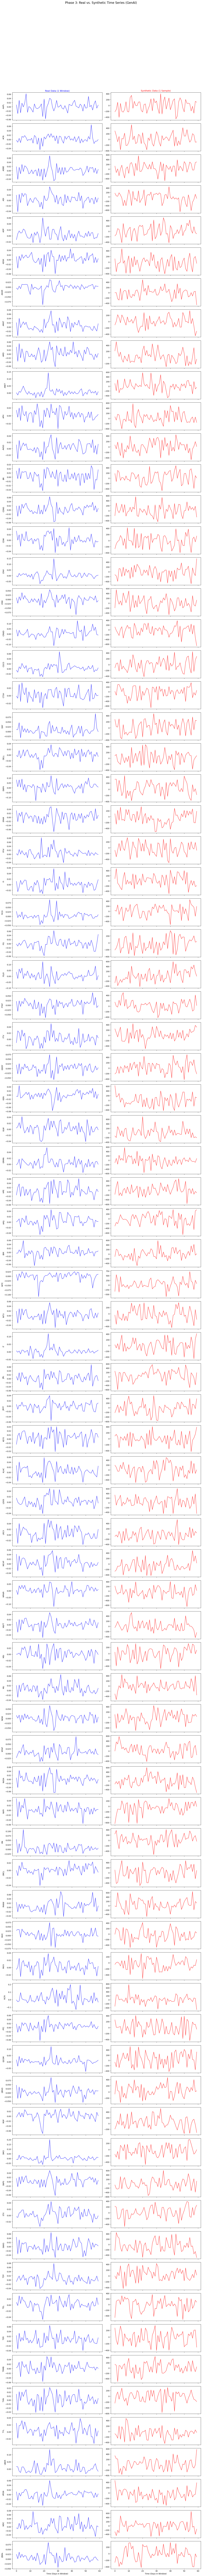

In [27]:
# --- 1. ตั้งค่า ---
# (ต้องตรงกับตอนเทรน)
device = "cuda" if torch.cuda.is_available() else "cpu"

# (ถ้าคุณรันใน Cell ใหม่ ต้องสร้าง scheduler อีกครั้งด้วยคลาสที่อัปเกรดแล้ว)
scheduler = DiffusionScheduler()

# --- 2. สั่ง Generate ---

# 🛑 สำคัญ! บอก PyTorch ว่าเรากำลัง "ใช้งาน" โมเดล (ไม่เทรนแล้ว)
#    (มันจะปิด Dropout, BatchNorm ฯลฯ ให้)
model.eval() 

print("กำลังสร้าง 4 ตัวอย่าง...")
N_SAMPLES_TO_GENERATE = 4

# (ดึงค่า N_ASSETS และ WINDOW_SIZE จากโมเดลที่คุณสร้าง)
N_ASSETS = model.n_assets
WINDOW_SIZE = model.window_size

# สั่งโรงงานให้เริ่มสร้าง!
synthetic_data = scheduler.p_sample_loop(
    model, 
    device, 
    n_samples=N_SAMPLES_TO_GENERATE,
    window_size=WINDOW_SIZE,
    n_assets=N_ASSETS
)

print(f"สร้างข้อมูลสังเคราะห์สำเร็จ! Shape: {synthetic_data.shape}")


# --- 3. พล็อตเปรียบเทียบ ---

print("กำลังพล็อตเปรียบเทียบ...")

# ดึงข้อมูล "จริง" 1 ตัวอย่างจาก dataset มาเทียบ
# (dataset คือ torch.tensor ที่คุณใช้ใน dataloader)
real_sample = dataset[0].numpy() 

# ดึงข้อมูล "ปลอม" 1 ตัวอย่างจาก GenAI
synthetic_sample = synthetic_data[0] 

# (ดึงชื่อ Ticker มาพล็อต)
# (ถ้าคุณไม่มี log_returns ให้ใช้ ['Asset 0', 'Asset 1', ...])
try:
    asset_names = log_returns.columns
except NameError:
    asset_names = [f'Asset {i}' for i in range(N_ASSETS)]


# --- เริ่มพล็อต ---
fig, axs = plt.subplots(N_ASSETS, 2, figsize=(15, N_ASSETS * 2.5), sharex=True)
fig.suptitle("Phase 3: Real vs. Synthetic Time Series (GenAI)", fontsize=16)

# ตั้งชื่อคอลัมน์
axs[0, 0].set_title("Real Data (1 Window)", color='blue')
axs[0, 1].set_title("Synthetic Data (1 Sample)", color='red')

for i in range(N_ASSETS):
    # พล็อตกราฟข้อมูลจริง
    axs[i, 0].plot(real_sample[:, i], color='blue', alpha=0.8)
    axs[i, 0].set_ylabel(asset_names[i])
    
    # พล็อตกราฟข้อมูลสังเคราะห์
    axs[i, 1].plot(synthetic_sample[:, i], color='red', alpha=0.8)

axs[-1, 0].set_xlabel("Time (Days in Window)")
axs[-1, 1].set_xlabel("Time (Days in Window)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()